In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import csv
import time
import matplotlib.pyplot as plt

class Mydataset(Dataset):
    
    def __init__(self, x, y=None):
        self.x = torch.FloatTensor(x)
        self.y = y
        if y is not None:
            self.y = torch.FloatTensor(y)
    
    def __getitem__(self, index):
        if self.y is None:
            return self.x[index]
        else:
            return self.x[index], self.y[index]
  
    def __len__(self):
        return len(self.x)

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
        )
  
    def forward(self, x):
        return self.net(x).squeeze(1)

def test(x, y, model):
    test_set = Mydataset(x)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    model.eval()
    ans = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data.cuda())
            for pred in test_pred:
                ans.append(float(pred.cpu().data.numpy()))
    return ans

array([[  621.65,  1324.6 ],
       [  609.67,  1324.6 ],
       [  610.92,  1323.65],
       ...,
       [46809.17,  1786.  ],
       [46078.38,  1788.25],
       [46368.69,  1794.6 ]])

In [18]:
dfg = pd.read_csv("LBMA-GOLD.csv")
dfb = pd.read_csv("BCHAIN-MKPRU.csv")

df = dfb
df["Gold"] = np.nan
tot = len(dfb)
p = len(dfg) - 1
pre = -1
for i in range(tot - 1, -1, -1):
    sl = dfb.iloc[i, 0]
    if (sl[0] == "2" and sl[1] == "0"):
        sl = sl[2:]
    if (sl[0] == "0"):
        sl = sl[1:]
        
    if (sl == dfg.iloc[p, 0]):
        df.iloc[i, 2] = dfg.iloc[p, 1]
        p -= 1
        
    if (np.isnan(df.iloc[i, 2])):
        df.iloc[i, 2] = df.iloc[i + 1, 2]     
    df.iloc[i, 0] = sl

#0是比特币 1是黄金
x = df.iloc[:, 1:3].values
x

jg = x
bl = np.zeros((tot, 2))
for i in range(1, tot):
    bl[i, 0] = x[i, 0] / x[i - 1 , 0]
    bl[i, 1] = x[i, 1] / x[i - 1, 1] 
bl[0, 0] = 1
bl[0, 1] = 1

x = bl

rate_j = 0.05
rate_pred = 0.05
rate_weng = 0.9

money = 1000
bit = 0
gold = 0
loutot = 0

for t1 in x[0:5, 0]:
    for t2 in x[0:5, 1]:
        loutot += t1 * t2

lis = []
jlis = []
money_lis = []
bit_lis = []
gold_lis = []
rsv = np.zeros((tot, 2))
k = np.zeros((tot, 2))
d = np.zeros((tot, 2))
j = np.zeros((tot, 2))
jwin = 7

alfb = 0.02
alfg = 0.01
zzc = []
for i in range(5, tot-1):
    r = np.mean(x[0:i+1, :], axis=0)
    delta = np.var(x[0:i+1, :], axis=0)
    # print("junzhi:", r)
    # print("fangcha", delta)
    # print("------------------------")
    # 投资策略
    for t1 in x[0:i, 0]:
        loutot += x[i, 1] * t1
    for t2 in x[0:i, 1]:
        loutot += x[i, 0] * t2
    loutot += x[i, 0] * x[i, 1]
    
    
    lou = loutot / (i + 1) / (i + 1) - r[0] * r[1]
    
    r_best = r[1] * delta[0] + r[0] * delta[1] - (np.sqrt(delta[0]) + np.sqrt(delta[1])) * lou
    r_best /= delta[0] + delta[1] - 2 * lou
    
    x0 = abs((r_best - r[1]) / (r[1] - r[0]))
    lis.append(x0)
    
    # J线
    
    mi = np.min(jg[max(i-jwin, 0):i, :], axis=0)
    mx = np.max(jg[max(i-jwin, 0):i, :], axis=0)
    # print(mi, mx)
    
    
    rsv[i] = (jg[i] - mi) / (mx - mi)
    
    if i == 5:
        k[i] = rsv[i]
        d[i] = rsv[i]
    else:
        k[i] = 2/3 * k[i-1] + 1/3 * rsv[i]
        d[i] = 2/3 * d[i-1] + 1/3 * k[i]
            
    j[i] = 3 * k[i] - 2 * d[i]
    
    
    if (j[i,0] < 0 and jg[i, 0] < mi[0]):
        bit += money * (1 - alfb) / jg[i, 0]
        money = 0
    
    if (j[i, 0] > 1 and jg[i, 0] > mx[0]):
        money += (1 - alfb) * bit * jg[i, 0]
        bit = 0
    
    if (j[i, 1] < 0 and jg[i, 1] < mi[1]):
        gold += money * (1 - alfg) / jg[i, 1]
        money = 0
    
    if (j[i, 1] > 1 and jg[i, 1] > mx[1]):
        money += (1 - alfg) * gold * jg[i, 1]
        gold = 0
    money_lis.append(money)
    bit_lis.append(bit)
    gold_lis.append(gold)
    
    zzc.append(money + bit * jg[i,0] * (1-alfb) + gold * jg[i,1] * (1-alfg))

zzc[-1]


59.00085197313692

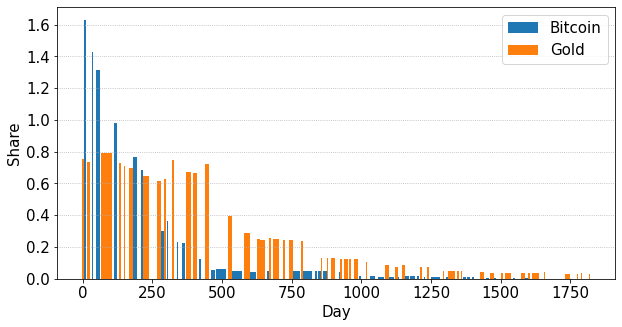

In [12]:
fig = plt.figure(figsize=(10, 5))
xzb = list(range(len(bit_lis)))
plt.bar(xzb, bit_lis, width=1.5, label="Bitcoin")
plt.bar(xzb, gold_lis, width=1.5, label="Gold")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Day", fontsize=15)
plt.ylabel("Share", fontsize=15)
plt.legend(fontsize=15)
plt.grid(b=True, axis='y', ls=':')
plt.savefig("kuishun.png")
plt.show()

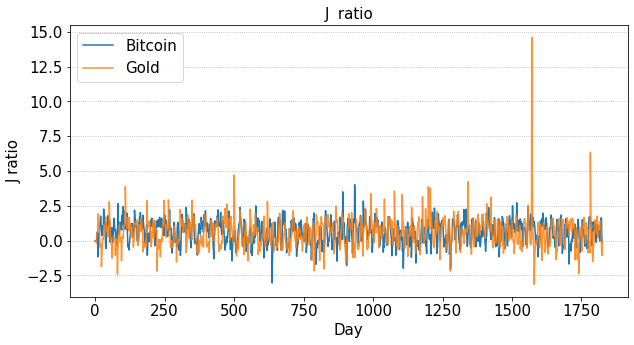

In [24]:
fig = plt.figure(figsize=(10, 5))
plt.plot(j[:, 0], label="Bitcoin")
plt.plot(j[:, 1], label="Gold", alpha = 0.85)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Day", fontsize=15)
plt.ylabel("J ratio", fontsize=15)
plt.grid(b=True, axis='y', ls=':')
plt.title("J  ratio", fontsize=15)
plt.legend(fontsize=15)
plt.grid(b=True, axis='y', ls=':')
# plt.savefig("J_ratio")
plt.show()

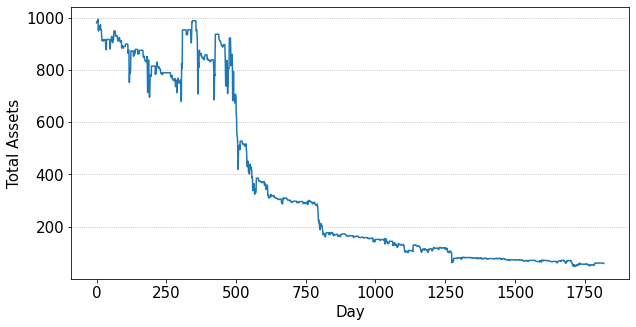

In [25]:
fig = plt.figure(figsize=(10, 5))
plt.plot(zzc)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Day", fontsize=15)
plt.ylabel("Total Assets", fontsize=15)
plt.grid(b=True, axis='y', ls=':')
plt.savefig("Kuishun.png")
plt.show()